# ML Algos

- Linear Regression 
- Support Vector Machine
- Random Forests

In [10]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import requests
import pickle 
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

df = pd.read_csv('BusRoutes.txt', sep='|')
print("Number of Routes >> " + str(df.shape[0]))

Number of Routes >> 48312


In [11]:
dfLPP = pd.read_csv('local_purchasing_power.csv')
dfLPP_2017 = dfLPP[['local', '2017']]
dfLPP_2017

,local,2017
0,Arcos de Valdevez,"67,8"
1,Caminha,"78,9"
2,Melgaço,"62,0"
3,Monção,"70,2"
4,Paredes de Coura,"66,4"
...,...,...
303,Ribeira Brava,"68,4"
304,Santa Cruz,"71,5"
305,Santana,"58,3"
306,São Vicente,"61,0"


## Links per Bus Route (e.g, road)

In [12]:
dfRoutesLinkCount = df.groupby('IDRoute', as_index=False)['linkid'].count() \
                                               .rename(columns={'linkid':'Number of Links'}) \
                                               .sort_values("Number of Links", ascending=False) 
dfRoutesLinkCount

,IDRoute,Number of Links
52,53,613
7,8,608
135,136,585
127,128,572
62,63,565
...,...,...
96,97,41
22,23,6
20,21,5
21,22,2


## Bus Routes per Link  

In [13]:
dfLinkRoutesCount = df.groupby('linkid', as_index=False)['IDRoute'].count() \
                                               .rename(columns={'IDRoute':'RoutesNumber'}) \
                                               .sort_values("RoutesNumber", ascending=False) 


dfLinkRoutesCount

,linkid,RoutesNumber
6679,724627591,20
15464,1172432839,20
6678,724627590,20
9401,836110932,20
6676,724627588,20
...,...,...
8991,812148656,1
8993,812148837,1
8995,812149330,1
9000,812234969,1


## Possible "stroke" points (Links with too many routes going through them)

In [14]:
dfSenior = pd.read_csv('Senior_TIM_v1.txt', sep='|', encoding= 'unicode_escape')
print("Number of Routes >> " + str(dfSenior.shape[0]))

Number of Routes >> 121053


In [15]:
dfSenior.columns


Index(['linkid', 'Region_of_Origin', 'District_of_Origin', 'County_of_Origin',
       'Average_Daily_SeniorPopulation_Travelling'],
      dtype='object')

In [16]:
dfSenior.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187
1,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396
2,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647248
3,80216810,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,233.203075
4,80216812,R1 - AM Lisboa,Lisboa,Lisboa,261.606014


In [17]:
joinedDf=dfSenior.merge(df)
joinedDf.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,8
1,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,85
2,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,8
3,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,85
4,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647248,8


# Links/Routes per Region, District and County

In [18]:
joinedDf.groupby("Region_of_Origin").agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values("NumberOfLinks", ascending=False) 

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
Region_of_Origin,,,
R1 - AM Lisboa,6184,160,576.977871
R2 - AM Porto,3803,133,2435.724436


In [19]:
joinedDf.groupby("District_of_Origin").agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values("NumberOfLinks", ascending=False) 

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
District_of_Origin,,,
Lisboa,5916,158,628.158972
Porto,3777,133,2451.672828
Setúbal,2368,141,365.034285
Aveiro,32,16,272.407024


In [20]:
linksRoutesPerOrigin=joinedDf.groupby(["District_of_Origin", "County_of_Origin"]).agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values(["District_of_Origin", "AvgDailyPopulation"], ascending=[True,  False]) 

linksRoutesPerOrigin

NumberOfLinks  NumberOfRoutes  \
District_of_Origin County_of_Origin                                      
Aveiro             Santa Maria da Feira             32              16   
Lisboa             Lisboa                         3832             132   
                   Odivelas                       1255             120   
                   Oeiras                         2824             152   
                   Vila Franca de Xira            1929             100   
                   Sintra                         1226             107   
                   Cascais                         472              98   
                   Amadora                         613              92   
                   Mafra                           283              81   
                   Loures                          141              51   
Porto              Maia                           2670              99   
                   Porto                          1478             110   
                   Gondomar                       1076              95   
                   Matosinhos                      195              33   
Setúbal            Palmela                         240              68   
                   Alcochete                         6               8   
                   Montijo                          55              15   
                   Barreiro                       1285             119   
                   Seixal                          942             110   
                   Setúbal                         113              29   
                   Sesimbra                         49              24   
                   Almada                          131              44   

                                         AvgDailyPopulation  
District_of_Origin County_of_Origin                          
Aveiro             Santa Maria da Feira          272.407024  
Lisboa             Lisboa                       1176.641628  
                   Odivelas                      715.200512  
                   Oeiras                        394.144009  
                   Vila Franca de Xira           364.993711  
                   Sintra                        351.236967  
                   Cascais                       285.334270  
                   Amadora                       155.706508  
                   Mafra                         144.367737  
                   Loures                        141.271239  
Porto              Maia                         3400.213919  
                   Porto                        2213.490123  
                   Gondomar                     1084.179459  
                   Matosinhos                    823.843490  
Setúbal            Palmela                       889.849297  
                   Alcochete                     544.140508  
                   Montijo                       441.206994  
                   Barreiro                      346.062201  
                   Seixal                        329.882526  
                   Setúbal                       138.546544  
                   Sesimbra                      116.808277  
                   Almada                         40.539317

## Open Weather Analysis

In [21]:
conversion_dic= {
    "Porto": "Porto",
    "Aveiro": "Aveiro",
    "Lisboa": "Lisbon",
    "Setúbal": "Setubal"
}

def get_lat_lon(district_name, city_name):
    print("Retrieving Lat and Long of {0} ({1})...".format(city_name, district_name))

    # If no city name is available then use district instead
    if city_name in conversion_dic:
        city_name=conversion_dic[city_name]
    
    url = "http://api.openweathermap.org/geo/1.0/direct?q=" + city_name + "&appid=155b4d6acbf49ae8044c54f654953578"

    request_json=requests.get(url).json()
    if len(request_json)==0:
        return get_history(district_name, district_name)
        
    return (request_json[0]["lat"], request_json[0]["lon"])


def get_air_polution(lat, lon, metric):
    print("Retrieving {0} ({1}) air polution...".format(lat, lon))
    
    url = "http://api.openweathermap.org/data/2.5/air_pollution?lat={0}&lon={1}&appid=155b4d6acbf49ae8044c54f654953578".format(lat, lon)

    request_json=requests.get(url).json()
        
    if metric==None:
        return request_json["list"][0]["main"]["aqi"]
    else:
        return request_json["list"][0]["components"][metric]
    
def get_history(district_name, city_name):
    print("Retrieving {0} ({1}) history...".format(city_name, district_name))

    # If no city name is available then use district instead
    if city_name in conversion_dic:
        city_name=conversion_dic[city_name]
    
    url = "http://history.openweathermap.org/data/2.5/aggregated/year?q=" + city_name + ",PT&appid=" + "155b4d6acbf49ae8044c54f654953578" \
                + "&start=2019-04-01" \
                + "&end=2020-03-31" \

    request_json=requests.get(url).json()
    if "result" not in request_json:
        return get_history(district_name, district_name)
        
    return pd.json_normalize(request_json["result"])

def get_agg_metric(district, city, col, agg_metric):
    df=get_history(district, city)
    return df.agg({col: agg_metric})[0] 

## Join Weather Cols

In [22]:
def apply_func(district_name, city_name, metric):
    lat_lon = get_lat_lon(district_name, city_name)
    return get_air_polution(lat_lon[0], lat_lon[1], metric)

#linksRoutesPerOrigin['AvgYearTemp'] = linksRoutesPerOrigin.apply(lambda row: get_agg_metric(row.name[0], row.name[1], "temp.mean", "mean"), axis=1)
#linksRoutesPerOrigin['AvgYearPrecipitation'] = linksRoutesPerOrigin.apply(lambda row: get_agg_metric(row.name[0], row.name[1], "precipitation.mean", "mean"), axis=1)
#linksRoutesPerOrigin['CO2Concentration'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], "co"), axis=1)
#linksRoutesPerOrigin['pm2_5Concentration'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], "pm2_5"), axis=1)
#linksRoutesPerOrigin['pm10Concentration'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], "pm10"), axis=1)

#linksRoutesPerOrigin['AirQuality'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], None), axis=1)

#linksRoutesPerOrigin.join(dfLPP, linksRoutesPerOrigin.name.County_of_Origin==dfLPP.local)

## Local purchasing power correlation

In [26]:
lppDf = pd.read_csv('local_purchasing_power.csv')

lppDf[['local', '2017']]

,local,2017
0,Arcos de Valdevez,"67,8"
1,Caminha,"78,9"
2,Melgaço,"62,0"
3,Monção,"70,2"
4,Paredes de Coura,"66,4"
...,...,...
303,Ribeira Brava,"68,4"
304,Santa Cruz,"71,5"
305,Santana,"58,3"
306,São Vicente,"61,0"


In [28]:
lppDf=pd.merge(linksRoutesPerOrigin, popDf, left_on="County_of_Origin", right_on='local')[['NumberOfLinks', 'NumberOfRoutes', "AvgDailyPopulation", "local", "2017"]]
lppDf["2017"]=popDf["2017"].apply(lambda row: float(row.replace(",", ".")))

lppDf

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,2017
0,32,16,272.407024,Santa Maria da Feira,67.8
1,3832,132,1176.641628,Lisboa,78.9
2,1255,120,715.200512,Odivelas,62.0
3,2824,152,394.144009,Oeiras,70.2
4,1929,100,364.993711,Vila Franca de Xira,66.4
5,1226,107,351.236967,Sintra,64.4
6,472,98,285.334270,Cascais,71.0
7,613,92,155.706508,Amadora,82.7
8,283,81,144.367737,Mafra,93.1
9,141,51,141.271239,Loures,84.2


<AxesSubplot:>

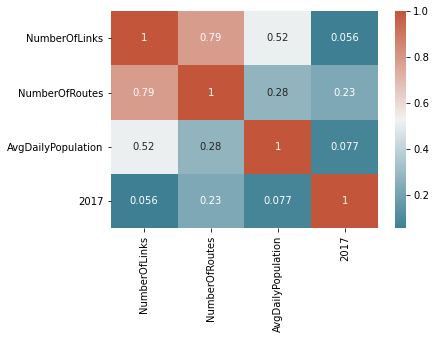

In [29]:
# calculate correlation matrix
corr = lppDf.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

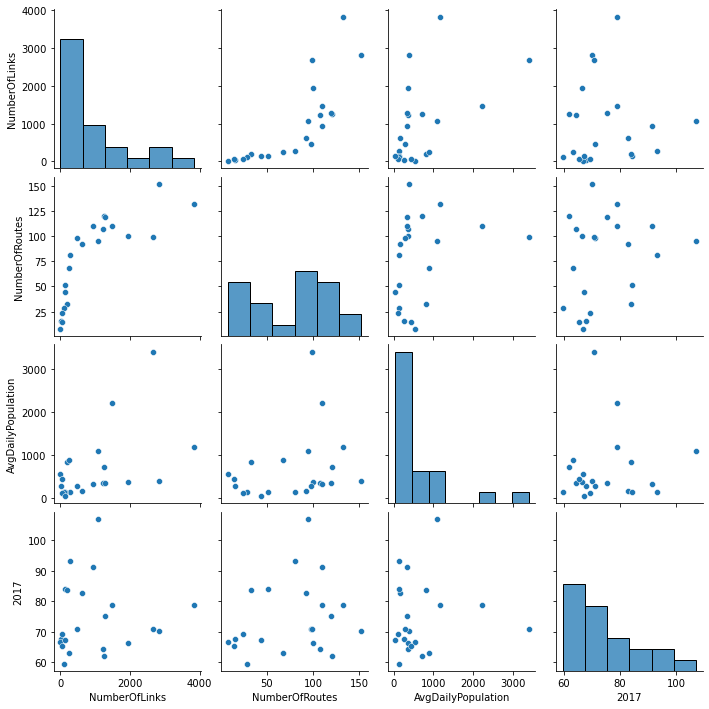

In [30]:
sns.pairplot(lppDf)

## Population density correlation

In [31]:
popDf = pd.read_csv('pop_density.csv')

popDf[['local', '2017']]

,local,2017
0,Arcos de Valdevez,"47,4"
1,Caminha,"116,7"
2,Melgaço,"34,9"
3,Monção,"85,7"
4,Paredes de Coura,"62,7"
...,...,...
304,Santa Cruz,"542,6"
305,Santana,"71,7"
306,São Vicente,"65,4"
307,Porto Santo,"120,1"


In [32]:
popDf=pd.merge(linksRoutesPerOrigin, popDf, left_on="County_of_Origin", right_on='local')[['NumberOfLinks', 'NumberOfRoutes', "AvgDailyPopulation", "local", "2017"]]
popDf["2017"]=popDf["2017"].apply(lambda row: float(row.replace(",", ".")))

popDf

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,2017
0,32,16,272.407024,Santa Maria da Feira,642.7
1,3832,132,1176.641628,Lisboa,5052.7
2,1255,120,715.200512,Odivelas,5913.9
3,2824,152,394.144009,Oeiras,3808.6
4,1929,100,364.993711,Vila Franca de Xira,443.2
5,1226,107,351.236967,Sintra,1206.0
6,472,98,285.334270,Cascais,2169.4
7,613,92,155.706508,Amadora,7529.7
8,283,81,144.367737,Mafra,284.4
9,141,51,141.271239,Loures,1246.7


<AxesSubplot:>

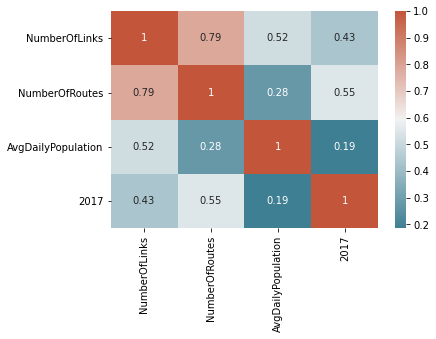

In [33]:
# calculate correlation matrix
corr = popDf.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

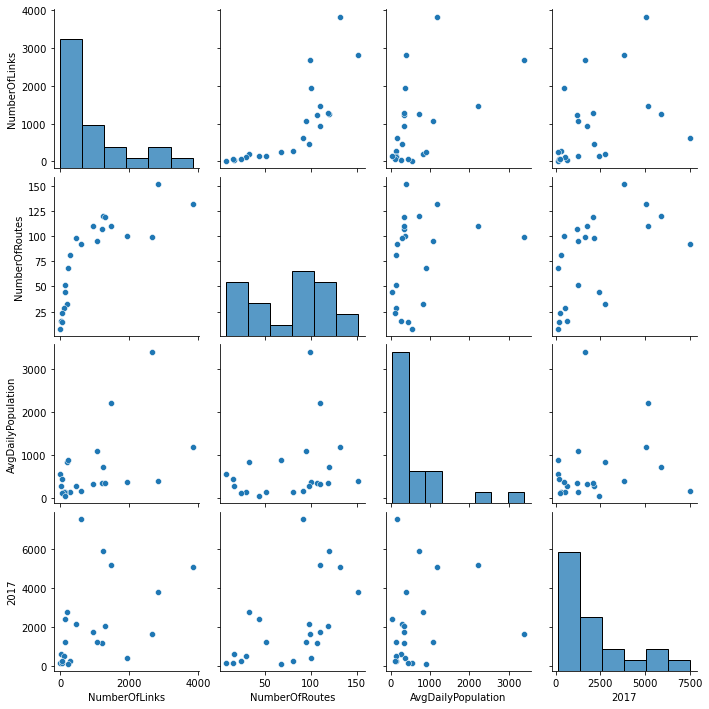

In [34]:
sns.pairplot(popDf)

## Senior citizen dependency correlation

In [35]:
depDf = pd.read_csv('senior_citizen_dependency.csv')
depDf[['local', '2019']]

,local,2019
0,Arcos de Valdevez,56.3
1,Caminha,41.0
2,Melgaço,65.3
3,Monção,48.5
4,Paredes de Coura,45.8
...,...,...
303,Ribeira Brava,25.0
304,Santa Cruz,15.9
305,Santana,37.9
306,São Vicente,39.7


In [36]:
linksRoutesPerOrigin

depDf=pd.merge(linksRoutesPerOrigin, depDf, left_on="County_of_Origin", right_on='local')[['NumberOfLinks', 'NumberOfRoutes', "AvgDailyPopulation", "local", "2019"]]
depDf["2019"]=depDf["2019"].apply(lambda row: float(row))

depDf

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,2019
0,32,16,272.407024,Santa Maria da Feira,27.7
1,3832,132,1176.641628,Lisboa,51.2
2,1255,120,715.200512,Odivelas,33.4
3,2824,152,394.144009,Oeiras,40.8
4,1929,100,364.993711,Vila Franca de Xira,27.4
5,1226,107,351.236967,Sintra,26.2
6,472,98,285.334270,Cascais,32.2
7,613,92,155.706508,Amadora,38.5
8,283,81,144.367737,Mafra,24.1
9,141,51,141.271239,Loures,35.0


<AxesSubplot:>

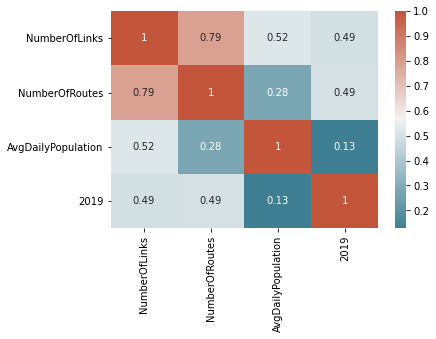

In [37]:
# calculate correlation matrix
corr = depDf.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

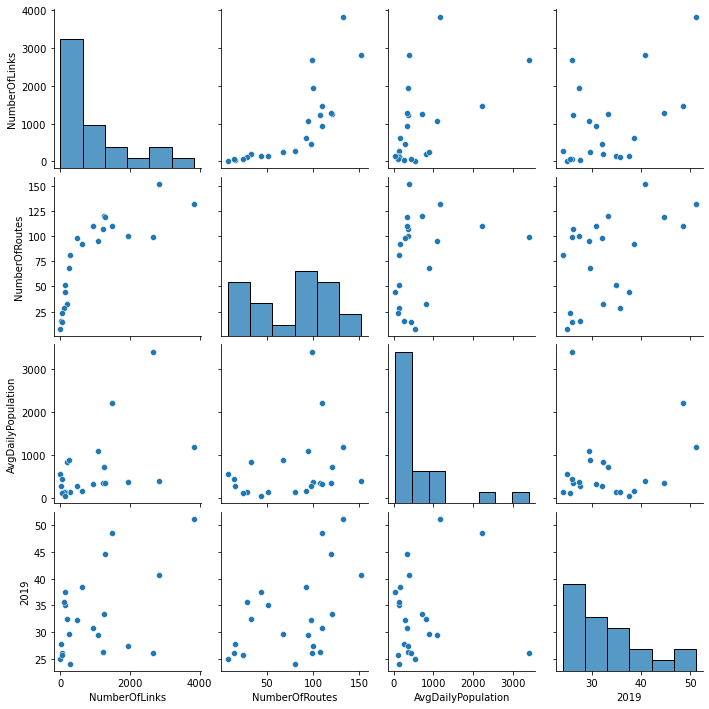

In [38]:
sns.pairplot(depDf)

## Old Age Index Correlation

In [39]:
ageDf = pd.read_csv('age_index.csv')

ageDf[['local', '2017']]

,local,2017
0,Arcos de Valdevez,"321,3"
1,Caminha,"227,5"
2,Melgaço,"437,7"
3,Monção,"302,4"
4,Paredes de Coura,"240,1"
...,...,...
303,Ribeira Brava,"111,9"
304,Santa Cruz,65
305,Santana,"236,5"
306,São Vicente,"237,3"


In [40]:
ageDf=pd.merge(linksRoutesPerOrigin, ageDf, left_on="County_of_Origin", right_on='local')[['NumberOfLinks', 'NumberOfRoutes', "AvgDailyPopulation", "local", "2017"]]
ageDf["2017"]=ageDf["2017"].apply(lambda row: float(row.replace(",", ".")))

ageDf

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,2017
0,32,16,272.407024,Santa Maria da Feira,132.6
1,3832,132,1176.641628,Lisboa,179.8
2,1255,120,715.200512,Odivelas,124.7
3,2824,152,394.144009,Oeiras,152.0
4,1929,100,364.993711,Vila Franca de Xira,104.5
5,1226,107,351.236967,Sintra,101.6
6,472,98,285.334270,Cascais,123.9
7,613,92,155.706508,Amadora,149.0
8,283,81,144.367737,Mafra,90.6
9,141,51,141.271239,Loures,134.6


<AxesSubplot:>

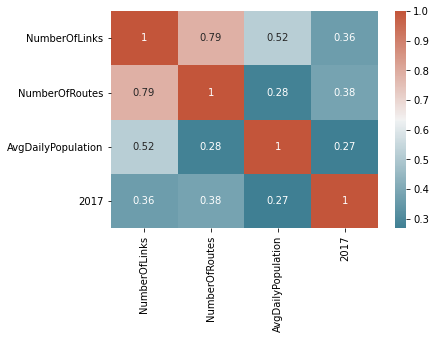

In [41]:
# calculate correlation matrix
corr = ageDf.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

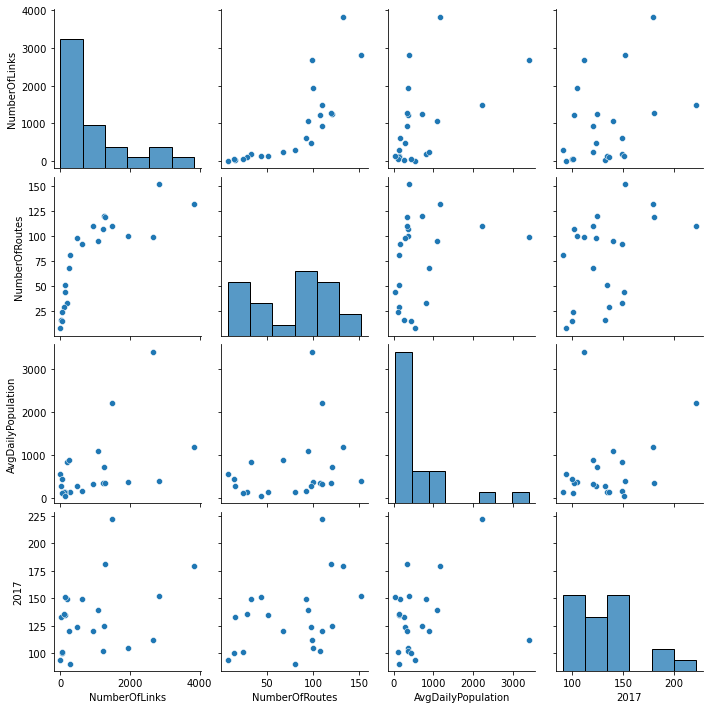

In [42]:
sns.pairplot(ageDf)

## Crimes per 1000 habitants

In [43]:
crimeDf = pd.read_csv('crimes_per_1000_people.csv')

crimeDf[['local', '2019']]

,local,2019
0,Arcos de Valdevez,"26,5"
1,Caminha,"32,7"
2,Melgaço,"25,5"
3,Monção,"18,3"
4,Paredes de Coura,"22,7"
...,...,...
304,Santa Cruz,"14,3"
305,Santana,"19,9"
306,São Vicente,"17,3"
307,Porto Santo,"31,8"


In [44]:
crimeDf=pd.merge(linksRoutesPerOrigin, crimeDf, left_on="County_of_Origin", right_on='local')[['NumberOfLinks', 'NumberOfRoutes', "AvgDailyPopulation", "local", "2019"]]
crimeDf["2019"]=crimeDf["2019"].apply(lambda row: float(row.replace(",", ".")))

crimeDf

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,2019
0,32,16,272.407024,Santa Maria da Feira,28.2
1,3832,132,1176.641628,Lisboa,69.1
2,1255,120,715.200512,Odivelas,21.2
3,2824,152,394.144009,Oeiras,22.8
4,1929,100,364.993711,Vila Franca de Xira,24.4
5,1226,107,351.236967,Sintra,29.6
6,472,98,285.334270,Cascais,30.3
7,613,92,155.706508,Amadora,31.6
8,283,81,144.367737,Mafra,24.2
9,141,51,141.271239,Loures,26.7


<AxesSubplot:>

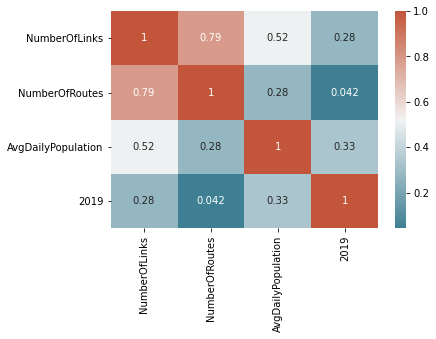

In [45]:
# calculate correlation matrix
corr = crimeDf.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

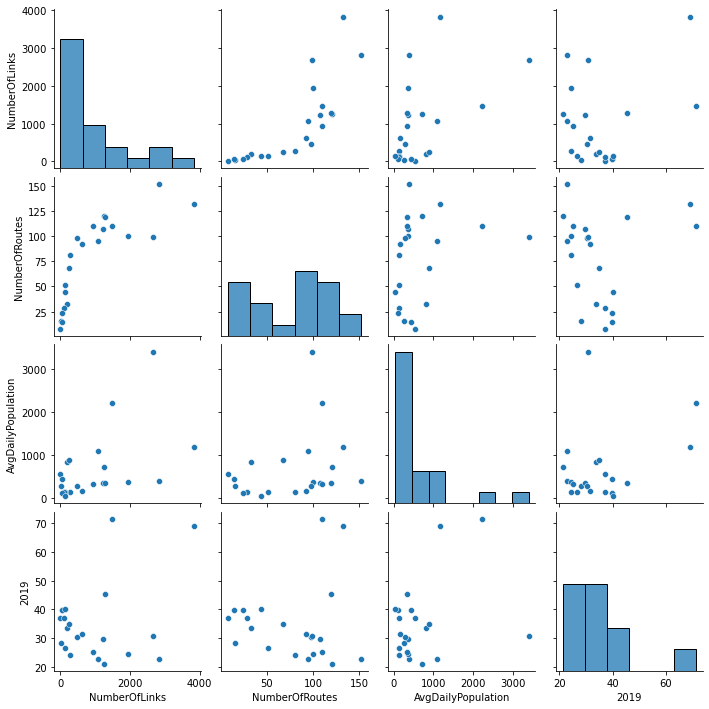

In [46]:
sns.pairplot(crimeDf)

Objectives:
- Verify if zones with high senior population that do not use public transports is somewhat related to economic reasons, lack of links/routes, or dependency index of senior citizens. 

Important Variables:
- Precipitation.
- Number of links.
- Number of routes.
- Old Age Index
- Local purchasing power

Relevant ML algorithms:
- 

In [48]:
popAgg = popDf.rename(columns={"2017": "DensidadePopulacional2017"})
popAgg.head()

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,DensidadePopulacional2017
0,32,16,272.407024,Santa Maria da Feira,642.7
1,3832,132,1176.641628,Lisboa,5052.7
2,1255,120,715.200512,Odivelas,5913.9
3,2824,152,394.144009,Oeiras,3808.6
4,1929,100,364.993711,Vila Franca de Xira,443.2


In [49]:
popAgg= pd.merge(popAgg, depDf, left_on="local", right_on='local')#[['NumberOfLinks', 'NumberOfRoutes', "AvgDailyPopulation", "local", "DensidadePopulacional", "2019"]]
popAgg = popAgg[["NumberOfLinks_x", "NumberOfRoutes_x", "AvgDailyPopulation_x", "local", "DensidadePopulacional2017", "2019"]] 
popAgg = popAgg.rename(columns={"NumberOfLinks_x": "NumberOfLinks", "NumberOfRoutes_x":"NumberOfRoutes",
                               "AvgDailyPopulation_x":"AvgDailyPopulation", "2019": "SeniorDependency2019"})
popAgg.head()

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,DensidadePopulacional2017,SeniorDependency2019
0,32,16,272.407024,Santa Maria da Feira,642.7,27.7
1,3832,132,1176.641628,Lisboa,5052.7,51.2
2,1255,120,715.200512,Odivelas,5913.9,33.4
3,2824,152,394.144009,Oeiras,3808.6,40.8
4,1929,100,364.993711,Vila Franca de Xira,443.2,27.4


In [50]:
dfPopSenior = pd.read_csv('pordata_residential_pop_2019.txt')
dfPopSenior = dfPopSenior[['local', '>65anos']]
dfPopSenior

,local,>65anos
0,Arcos de Valdevez,6807
1,Caminha,4110
2,Melgaço,2941
3,Monção,5275
4,Paredes de Coura,2381
...,...,...
303,Ribeira Brava,2157
304,Santa Cruz,5331
305,Santana,1673
306,São Vicente,1307


In [51]:
ageDf2 = pd.read_csv('age_index.csv')
ageDf2 = ageDf2[['local', '2019']]
ageDf2["2019"]=ageDf2["2019"].apply(lambda row: float(row.replace(",", ".")))

popAgg= pd.merge(popAgg, dfPopSenior, left_on="local", right_on='local')
popAgg = popAgg.rename(columns={">65anos":"SeniorResidentPop2019"})
popAgg= pd.merge(popAgg, ageDf2, left_on="local", right_on='local')
popAgg = popAgg.rename(columns={"2019":"IndexEnvelh2019"})

popAgg.head()

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,DensidadePopulacional2017,SeniorDependency2019,SeniorResidentPop2019,IndexEnvelh2019
0,32,16,272.407024,Santa Maria da Feira,642.7,27.7,26631,148.0
1,3832,132,1176.641628,Lisboa,5052.7,51.2,144050,171.5
2,1255,120,715.200512,Odivelas,5913.9,33.4,34005,126.5
3,2824,152,394.144009,Oeiras,3808.6,40.8,43787,159.5
4,1929,100,364.993711,Vila Franca de Xira,443.2,27.4,26119,114.5


In [53]:
popAgg["PercSeniorAvgDailyPopulation"] = \
    popAgg.apply(lambda x : x["AvgDailyPopulation"]*100/x["SeniorResidentPop2019"], axis=1)
    
popAgg.head()

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,local,DensidadePopulacional2017,SeniorDependency2019,SeniorResidentPop2019,IndexEnvelh2019,PercSeniorAvgDailyPopulation
0,32,16,272.407024,Santa Maria da Feira,642.7,27.7,26631,148.0,1.022894
1,3832,132,1176.641628,Lisboa,5052.7,51.2,144050,171.5,0.816829
2,1255,120,715.200512,Odivelas,5913.9,33.4,34005,126.5,2.103222
3,2824,152,394.144009,Oeiras,3808.6,40.8,43787,159.5,0.900139
4,1929,100,364.993711,Vila Franca de Xira,443.2,27.4,26119,114.5,1.397426


<AxesSubplot:>

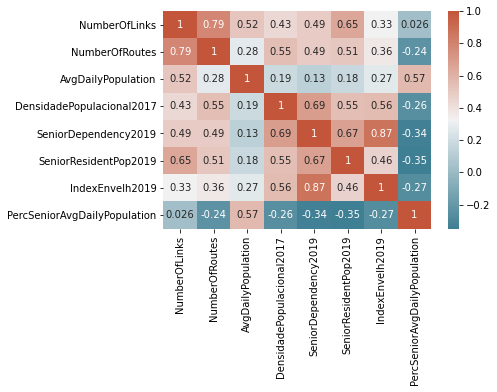

In [54]:
corr = popAgg.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

#### Verifica-se que PercSeniorAvgDailyPopulation é inversamente proporcional ao SeniorDependency2019, o que significa que quanto maior é o número de idosos dependentes no município, menor é o número de utilizadores idosos

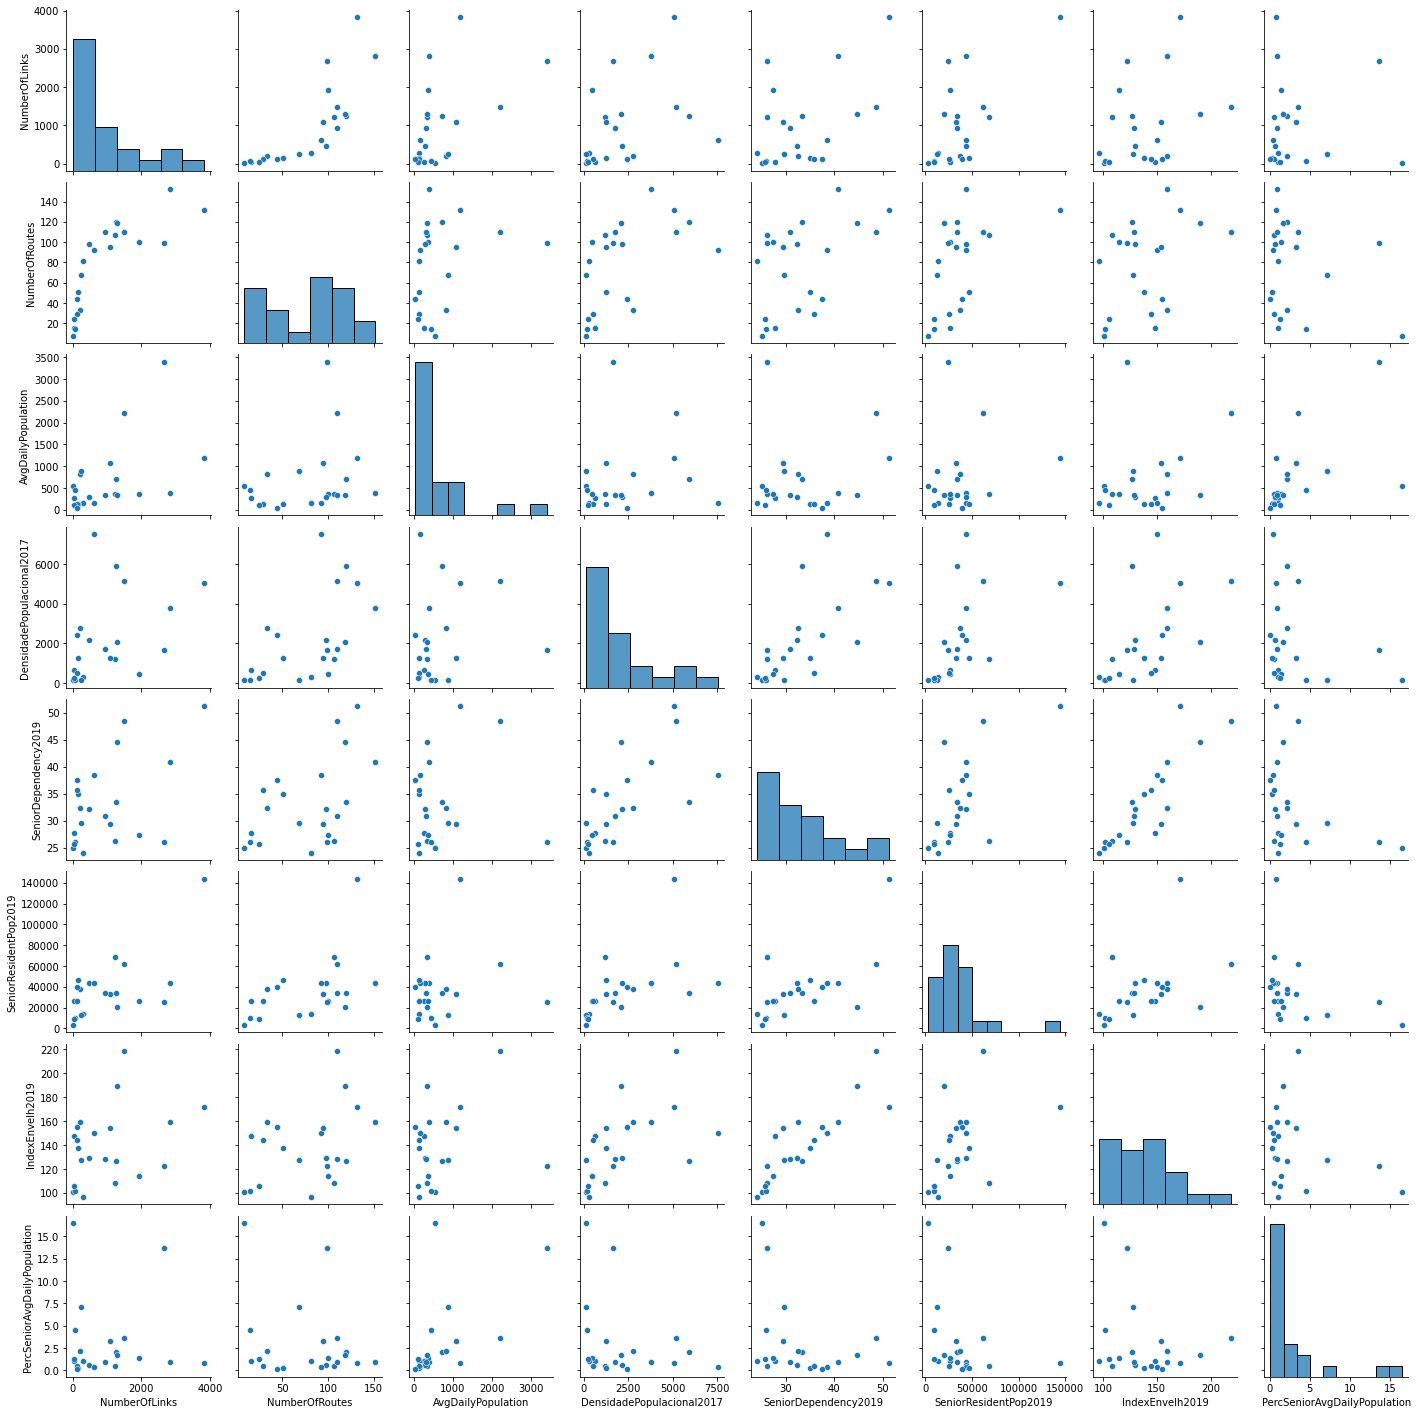

In [55]:
sns.pairplot(popAgg)

In [58]:
popAgg.columns

Index(['NumberOfLinks', 'NumberOfRoutes', 'AvgDailyPopulation', 'local',
       'DensidadePopulacional2017', 'SeniorDependency2019',
       'SeniorResidentPop2019', 'IndexEnvelh2019',
       'PercSeniorAvgDailyPopulation'],
      dtype='object')

In [79]:
import pandas
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import numpy as np

In [94]:
x = popAgg.iloc[:, [0,1, 3, 4, 5, 6]]
y = popAgg.iloc[:, 2]

In [95]:
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(X)

In [96]:
scores = []
best_svr = SVR(kernel='rbf')
cv = KFold(n_splits=10)
for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    best_svr.fit(X_train, y_train)
    scores.append(best_svr.score(X_test, y_test))

Train Index:  [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 

Test Index:  [0 1 2]
Train Index:  [ 0  1  2  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 

Test Index:  [3 4 5]
Train Index:  [ 0  1  2  3  4  5  8  9 10 11 12 13 14 15 16 17 18 19 20 21] 

Test Index:  [6 7]
Train Index:  [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 20 21] 

Test Index:  [8 9]
Train Index:  [ 0  1  2  3  4  5  6  7  8  9 12 13 14 15 16 17 18 19 20 21] 

Test Index:  [10 11]
Train Index:  [ 0  1  2  3  4  5  6  7  8  9 10 11 14 15 16 17 18 19 20 21] 

Test Index:  [12 13]
Train Index:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 17 18 19 20 21] 

Test Index:  [14 15]
Train Index:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21] 

Test Index:  [16 17]
Train Index:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 20 21] 

Test Index:  [18 19]
Train Index:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 

Test Index:  [20 21]


In [97]:
best_svr.fit(X_train, y_train)
scores.append(best_svr.score(X_test, y_test))

In [98]:
scores

[-0.9976965461966179,
 -1.6889608425237612,
 -5.828500690760826,
 -22911.09181174203,
 -17.14548045822437,
 -21.78372732798626,
 -4.64766400974798,
 -0.691628854313389,
 -2.239572819850252,
 -61.749699925995095,
 -61.749699925995095]

In [90]:
cross_val_score(best_svr, X, y, cv=10)


array([-9.97696546e-01, -1.68896084e+00, -5.82850069e+00, -2.29110918e+04,
       -1.71454805e+01, -2.17837273e+01, -4.64766401e+00, -6.91628854e-01,
       -2.23957282e+00, -6.17496999e+01])